In [25]:
import numpy as np
from sklearn.datasets import load_digits #手写数字数据集
from sklearn.preprocessing import LabelBinarizer #标签二值化处理
from sklearn.model_selection import train_test_split #训练和测试集分隔
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split #训练和测试集分隔
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# 载入数据
digits = load_digits()

# 输入的数据
X = digits.data
X = X.reshape([X.shape[0],-1])
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
# 标签数据
T = digits.target
# 数据切分，默认测试集占0.25
X_train,X_test,y_train,y_test = train_test_split(X,T)
# (1797,) [0 1]
labels_train = LabelBinarizer().fit_transform(y_train)


In [4]:
print(y_test.shape)

(450,)


In [29]:
class NeuralNetwork:
    def __init__(self,layers,alpha=0.1):
        self.W = []
        self.layers = layers
        self.alpha = alpha
        self.dropoutV = []
        #为隐藏层初始化权重
        for i in range(0,len(layers)-2):
            w = np.random.randn(layers[i]+1,layers[i+1]+1)
            self.W.append(w/np.sqrt(layers[i]))
            
        w = np.random.randn(layers[-2]+1,layers[-1])
        self.W.append(w/np.sqrt(layers[-2]))
    
    def softMax(self,x):
        max_dict = [ [np.max(i)] for i in x]
        x = np.exp((x-max_dict))
        
        return np.array([ i/np.sum(i) for i in x])
    
    def Leaky_Relu(self,x):
        activations = x.copy()
        activations[activations<0] = activations[activations<0]*0.01
        
        return activations
    
    def Leaky_Relu_deriv(self,x):
        deriv = np.ones_like(x)
        deriv[x<0] = 0.01
        
        return deriv
    
    def sigmoid(self,x):
        return 1.0/(1+np.exp(-x))
    
    def sigmoid_deriv(self,x):
        return x*(1-x)
    
    def getDropoutVec(self,p,size):
        """
        Get a vector that is all compenented of 0 or 1
        the probability of selecting 1 is p
        
        Parameters
        -----
        p : float in [0,1)
            The dropout probability during 
        size : list of shape (n,m)
            the shape of dropout vector
        """
        p_Vector = np.random.randn(size[0],size[1])
        dropoutVector = p_Vector > p
        return dropoutVector
    
    def fit(self,X,y,epochs = 1000,displayUpdate = 100,batch_size=1.0,alpha=1e-2):
        X = np.c_[X,np.ones((X.shape[0]))]
        
        for epoch in range(epochs):
            batch_index = np.random.choice(X.shape[0],batch_size,True)
            batch_X = X[batch_index,:]
            batch_Y = y[batch_index]
#             self.fit_partial(batch_X,batch_Y,batch_size)
            self.fit_partial_likehood(batch_X,batch_Y,batch_size,alpha)
    
            if epoch == 0 or (epoch+1)%displayUpdate==0:
#                 loss = self.calculate_loss(X,y)
                loss = self.calculate_loss_likehood(X,y)
                print("[INFO] epoch={},loss={:.7f},acc={}".format(epoch+1,loss,self.calculate_acc(X_test,y_test)))
                
    def fit_partial_likehood(self,x,y,batch_size,p=0.5,alpha=1e-2):
        A = [np.atleast_2d(x)]
        _net = []#save the result of the current layer  to calculate the gradient of leaky_relu
        
        #进行隐藏层计算
        for layer in range(len(self.W)-1):
            net = A[layer].dot(self.W[layer])
#             print('net',net)
#             scaler = StandardScaler()
#             net = scaler.fit_transform(net)
            _net.append(net)
            out = self.Leaky_Relu(net)
#             out = self.sigmoid(net)
#             print('out',out)


            dropout_V = self.getDropoutVec(p,[1,out.shape[1]])
#             out = out*dropout_V
            
            self.dropoutV.append(dropout_V)
            A.append(out)
        
        A.append(A[-1].dot(self.W[-1]))
        
        #uniform the update formula of hidden layer and output layer,add a dropout layer
        #that is all compenented of 1 
        dropout_V = np.ones((A[-1].shape[1]))
        self.dropoutV.append(dropout_V)
        
        #通过softMax激活函数
        A[-1] = self.softMax(A[-1])
#         print("softMax",A[-1])
        #计算输出层的梯度
        D = [A[-1]-y]
#         print('lastD',D)
        #计算隐藏层的梯度
        for layer in np.arange(len(A)-2,0,-1):
            delta = D[-1].dot(self.W[layer].T)
#             print('Rel_Deriv',self.Leaky_Relu_deriv(_net[layer-1]))
            delta = delta*self.Leaky_Relu_deriv(_net[layer-1])
#             delta = delta*self.sigmoid_deriv(A[layer])
            D.append(delta)
        
        D = D[::-1]
        
        #更新权重
        for layer in range(len(self.W)):
#             print('D',layer,1.0/batch_size*self.alpha*(0.9*self.W[layer]+A[layer].T.dot(D[layer])))
            self.W[layer] -=1.0/batch_size*alpha*(0.9*self.W[layer]+A[layer].T.dot(D[layer]))
#             self.W[layer] -= 1.0/batch_size*self.alpha*A[layer].T.dot(D[layer]*self.dropoutV[layer])

    def fit_partial(self,x,y,batch_size):
        A = [np.atleast_2d(x)]
        for layer in range(len(self.W)):
            net = A[layer].dot(self.W[layer])
            
            out = self.sigmoid(net)
            
            A.append(out)
            
        error = A[-1] - y
        
        D = [error*self.sigmoid_deriv(A[-1])]

        for layer in np.arange(len(A)-2,0,-1):
            delta = D[-1].dot(self.W[layer].T)
            delta = delta * self.sigmoid_deriv(A[layer])
            
            D.append(delta)
        
        D = D[::-1]
        
        for layer in range(len(self.W)):
            self.W[layer]+= -1.0/batch_size*self.alpha*A[layer].T.dot(D[layer])
            
    def predict(self,x,addBias=True):
        p = x
        print('predict')
        
        if addBias ==True:
            p = np.c_[p,np.ones((p.shape[0]))]
        for i in range(len(self.layers)-1):
            print(i)
            p =self.sigmoid(p.dot(self.W[i]))
        return p
    
    def predict_softmax(self,x,addBias=True):
        p = x
        
        if addBias ==True:
            p = np.c_[p,np.ones((p.shape[0]))]
        for i in range(len(self.layers)-2):
            p =self.sigmoid(p.dot(self.W[i]))
        p = self.softMax(p.dot(self.W[-1]))
        return p
    
    def calculate_loss(self,X,targets):
        targets = np.atleast_2d(targets)
        
        predictions = self.predict(X,False)
        loss = 0.5*np.sum((predictions-targets)**2)
        
        return loss
    
    def calculate_loss_likehood(self,X,y):
        predictions = self.predict_softmax(X,False)
        loss = -sum(np.sum(y*np.log(predictions),1))
        loss += self.sum_weight()
        return loss
    
    def calculate_acc(self,X,y):
        predictions = self.predict_softmax(X,True)
        predictions = np.argmax(predictions,axis=1)
        result = np.array(predictions)==np.array(y)
        return (1.0*sum(result)/len(result))
    
    def sum_weight(self):
        _sum = 0
        for i in self.W:
            _sum+= np.sum(i**2)
        return _sum

In [30]:
nn = NeuralNetwork([64,32,16,10], alpha=1e-3) 

In [41]:

nn.fit(X_train, labels_train,epochs=1000,displayUpdate=100,batch_size=512,alpha=1e-3)

[INFO] epoch=1,loss=3014.7539381,acc=0.16444444444444445
[INFO] epoch=100,loss=3014.2675410,acc=0.16444444444444445
[INFO] epoch=200,loss=3013.8471921,acc=0.17333333333333334
[INFO] epoch=300,loss=3013.6741915,acc=0.1711111111111111
[INFO] epoch=400,loss=3011.9829981,acc=0.1711111111111111
[INFO] epoch=500,loss=3012.0296875,acc=0.1711111111111111
[INFO] epoch=600,loss=3012.7937188,acc=0.1711111111111111
[INFO] epoch=700,loss=3009.5620409,acc=0.1711111111111111
[INFO] epoch=800,loss=3010.4994733,acc=0.1688888888888889
[INFO] epoch=900,loss=3008.1021994,acc=0.18222222222222223
[INFO] epoch=1000,loss=3008.8433808,acc=0.18222222222222223


In [209]:
output = nn.predict_softmax(X_test)
predictions = np.argmax(output,axis=1)
print(classification_report(predictions,y_test))


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.00      0.00      0.00         0
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         0
          4       1.00      0.12      0.21       450
          5       0.00      0.00      0.00         0
          6       0.00      0.00      0.00         0
          7       0.00      0.00      0.00         0
          8       0.00      0.00      0.00         0
          9       0.00      0.00      0.00         0

avg / total       1.00      0.12      0.21       450



D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[ 0.  0.  2. 12. 12.  0.  0.  0.  0.  0.  7. 16. 15.  9.  1.  0.  0.  0.
  6. 14. 13. 15.  3.  0.  0.  0.  1. 16. 16.  4.  0.  0.  0.  0.  7. 16.
 14.  0.  0.  0.  0.  1. 15.  9. 16.  5.  0.  0.  0.  2. 13. 13. 16. 10.
  0.  0.  0.  0.  1. 11. 12.  5.  0.  0.]
8


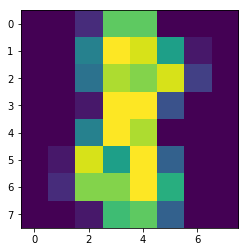

In [161]:
print(X_test[3])
print(y_test[3])
import matplotlib.pyplot as plt
plt.imshow(X_test[3].reshape((8,8)))
plt.show()

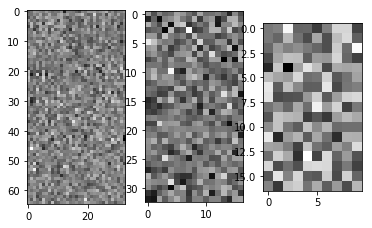

In [15]:
import matplotlib.pyplot
plt.figure()
plt.subplot(1,3,1)
plt.imshow(nn.W[0],cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.imshow(nn.W[1],cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.imshow(nn.W[2],cmap=plt.cm.gray)
plt.show()
